## Pretrained GAN

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

Prepare the input data by crappifying images.

In [3]:
from crappify import *

Uncomment the first time you run this notebook.

In [4]:
il = ImageList.from_folder(path_hr)
# fastai has a function called parallel, which takes a function and a list of things to operate on
parallel(crappifier(path_lr, path_hr), il.items)

For gradual resizing we can change the commented line here.

In [6]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256


## Pre-train generator

Now let's pretrain the generator.

In [7]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [8]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [9]:
data_gen = get_data(bs,size)

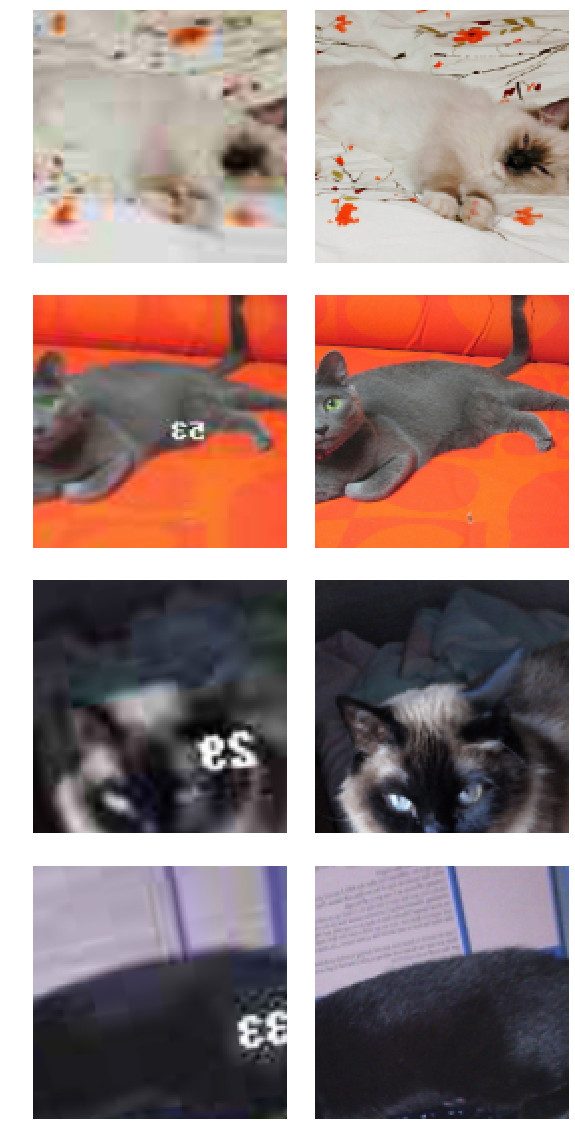

In [10]:
data_gen.show_batch(4)

In [11]:
wd = 1e-3

In [12]:
y_range = (-3.,3.)

In [13]:
# MSE between pixel values that we generated and actual pixel values
# MSELossFlat flattens out the image into a vector of pixels
loss_gen = MSELossFlat()

In [14]:
# using a pretrained model as it already knows how to understand these images
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [15]:
# here we create a unet, of which the downsampling part is a pretrained resnet
learn_gen = create_gen_learner()

In [16]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [17]:
# unfreeze the downsampling part (where the resnet is)
learn_gen.unfreeze()

In [18]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

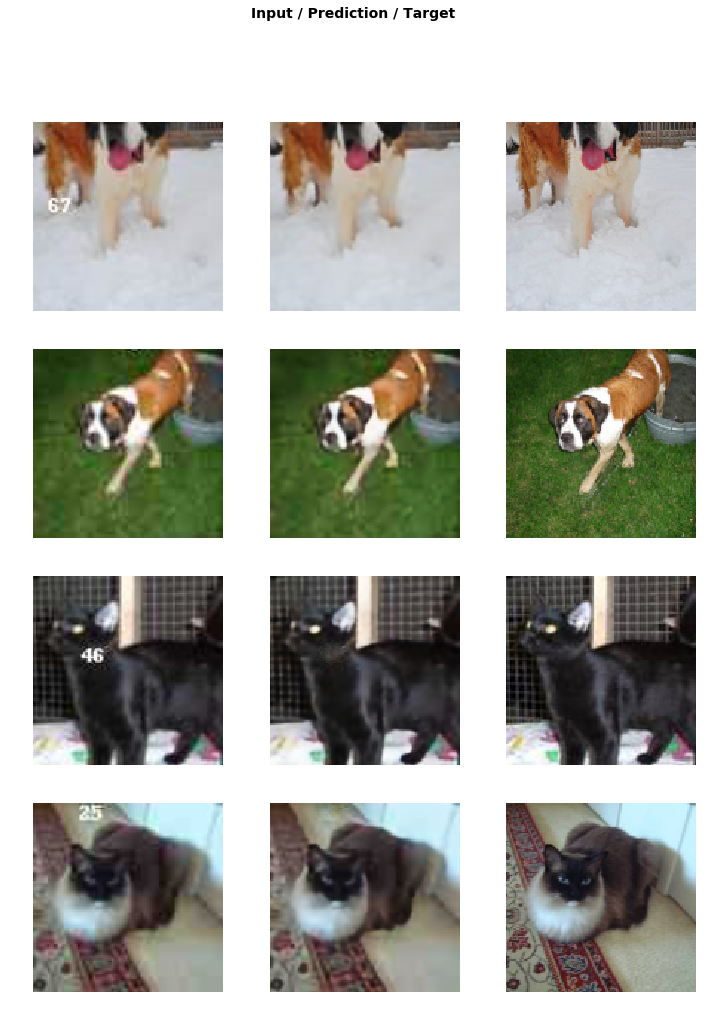

In [19]:
# these reproductions are OK, and actually pretty good with respect to MSE
# MSE will never be able to capture the specific textures as most pixels are similar
# Instead we want to use a GAN, whose loss function calls a discriminator network. The loss function is then 
# 'how good are we at fooling the discriminator'.
# After a while we train the discriminator on the better generated images, so it gets better. 

# In the fastai version of GANs the generator and the critic are pretrained.
learn_gen.show_results(rows=4)

In [20]:
learn_gen.save('gen-pre2')

## Save generated images

We're making a folder with the generated, crappified images so we can train the discriminator on these vs the 
originals.

In [21]:
learn_gen.load('gen-pre2');

In [22]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [23]:
# shutil.rmtree(path_gen)

In [24]:
path_gen.mkdir(exist_ok=True)

In [25]:
def save_preds(dl):
    i=0
    # filenames in dataset
    names = dl.dataset.items
    
    # for batch in dataset:
    for b in dl:
        # grab a bunch of predictions, and create fastai image objects for each item in the batch
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [26]:
save_preds(data_gen.fix_dl)

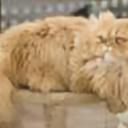

In [27]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [28]:
# reclaim GPU memory (without restarting notebook):

# set something that was using lots of GPU memory to None
learn_gen=None

# then run this
gc.collect()

20

Pretrain the critic on crappy vs not crappy.

In [29]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [30]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

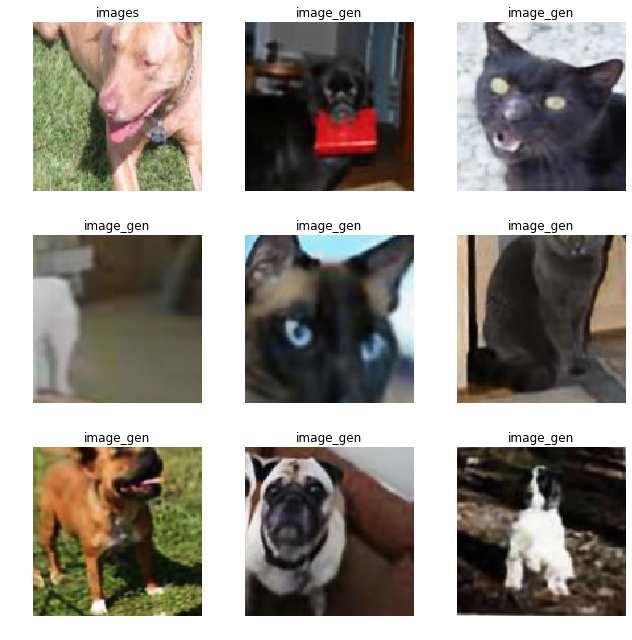

In [31]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [32]:
# using binary cross entropy as usual
# adaptiveloss 'Expands the target to match the output size before applying crit'. Use whenever using a GAN
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [33]:
# not using a resnet - this is a specific fastai learner made to be a gan critic
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [34]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [35]:
learn_critic.fit_one_cycle(6, 1e-3)

In [36]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [37]:
learn_crit=None
learn_gen=None
gc.collect()

15857

In [38]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [39]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [40]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

The GAN isn't just used as a loss function, as it measures generation of a *realistic* image rather than the actual image. This GAN implementation combines pixel MSE with the discriminator prediction to produce an overall loss for the critic.

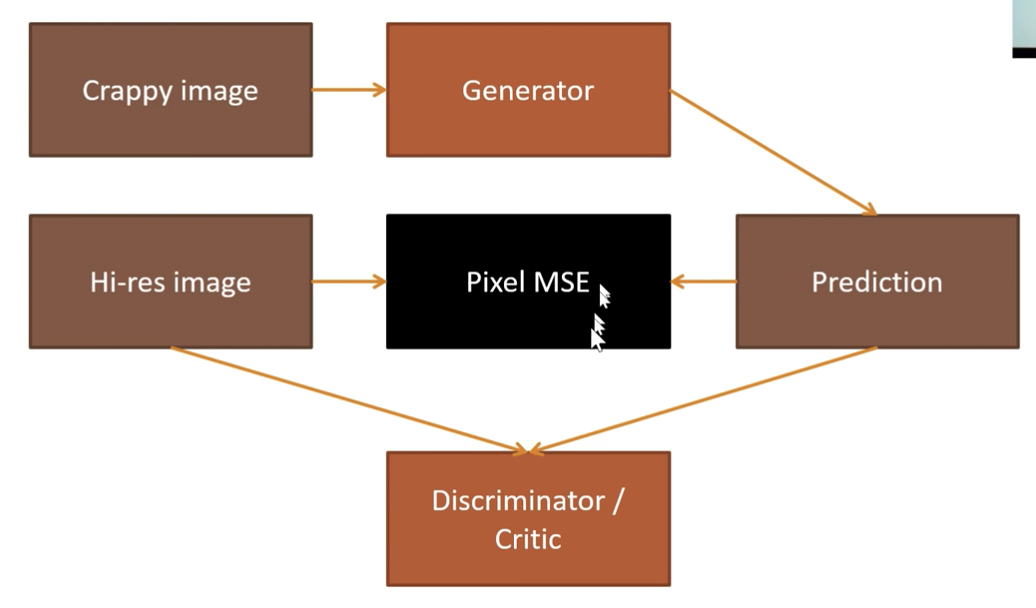

In [41]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
# weights_gen changes the weights of the pixel loss vs the critic loss
# betas in the adam optimizer sets momentum to zero - switching between the generator and the critic means momentum
# doesn't really work
# can use show_img = True to show images after every epoch
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [42]:
lr = 1e-4

In [ ]:
# the loss numbers for GANs are meaningless - as the generator gets better it gets harder for the critic, 
# and then when the critic gets better it gets harder for the generator
learn.fit(40,lr)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,lr/2)

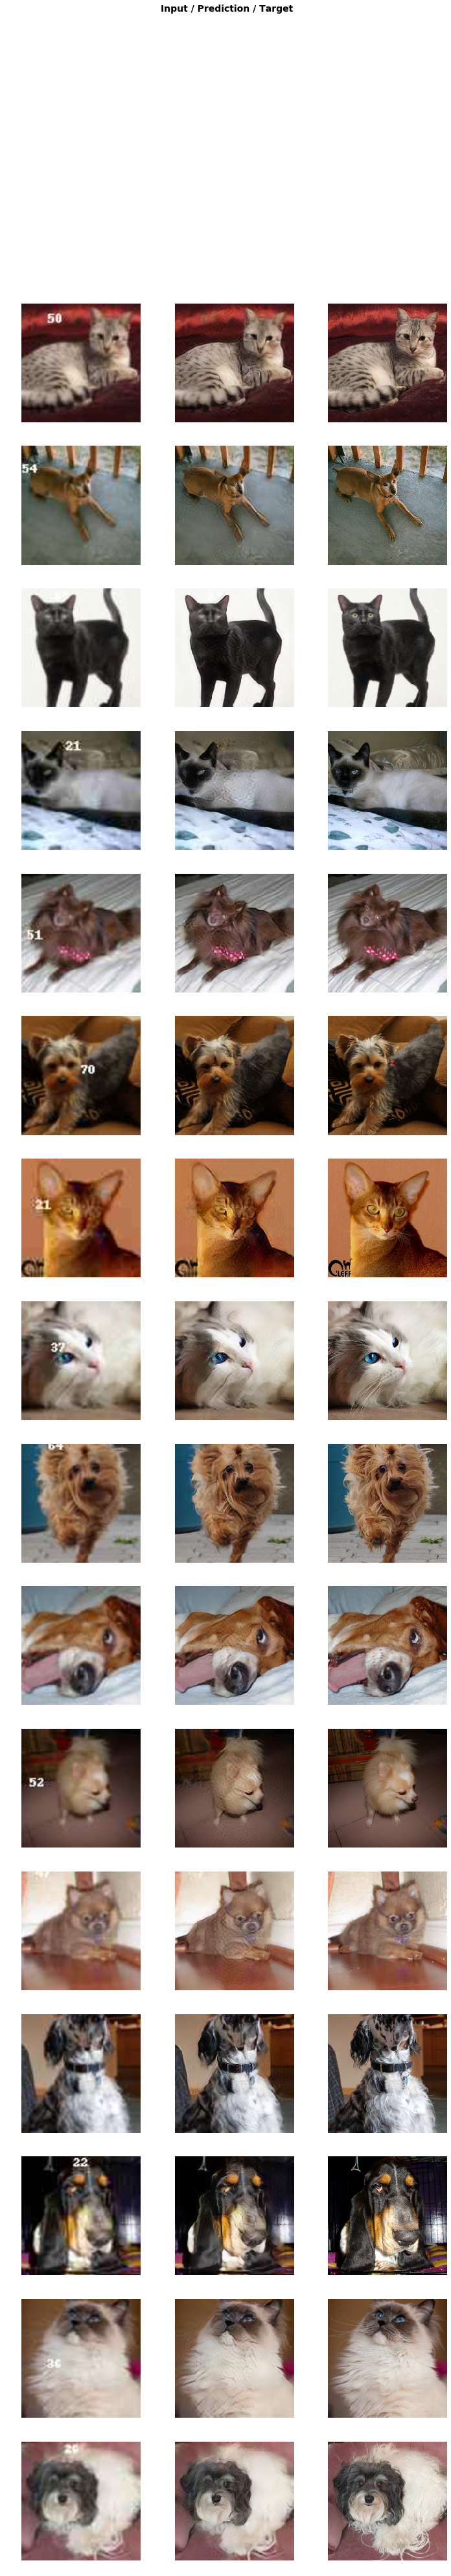

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')

## fin